# Green Kubo Thermal Conductivity Calculator <br>
#### By Ernesto Barraza-Valdez 
#### ernestob@uci.edu 
#### 10/30/2020 

This notebook is to calculate the thermal conductivity using the Green-Kubo Heat Flux autocorrelation method. The steps and techniques are followed from Chen et al:

Chen, J., Zhang, G., & Li, B. (2010). How to improve the accuracy of equilibrium molecular dynamics for computation of thermal conductivity?. Physics Letters A, 374(23), 2392-2396.

We have used a 15x15x15 (lattice parameter) Si system with a total of 27,000 atoms at 1,000K. 
LAMMPS is told to calculate and output the total heat flux using *compute heat/flux* in the folowing way:

compute         myKE all ke/atom <br>
compute         myPE all pe/atom <br>
compute         myStress all stress/atom NULL virial <br>
compute         flux all heat/flux myKE myPE myStress <br>
variable        Jx equal c_flux[1]/vol <br>
variable        Jy equal c_flux[2]/vol <br>
variable        Jz equal c_flux[3]/vol <br>

The heat flux outputs for *Jx*, *Jy*, *Jz* were converted to a .csv file where it is then imported into python via pandas

Note: Chen et al uses Stillinger-Weber potential for Si. In this notebook, tersoff potential is used. 


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

We load the heat flux values from a csv file using pandas data analytics library

In [2]:
HF = pd.read_csv("Flux1000k.csv")

In [3]:
print(HF.head())

   Step        Temp      v_Jx      v_Jy      v_Jz
0     0  1000.00000  0.000362  0.002685 -0.003382
1     1   999.05959  0.000145  0.002669 -0.003291
2     2   998.05535 -0.000184  0.002560 -0.003156
3     3   997.07572 -0.000555  0.002386 -0.002975
4     4   996.17734 -0.000844  0.002139 -0.002719


After reading the heat fluxes from the csv file we convert the data into numpy array

In [12]:
Jx = np.transpose(HF[['v_Jx']].values)[0];
Jy = np.transpose(HF[['v_Jy']].values)[0];
Jz = np.transpose(HF[['v_Jz']].values)[0];

---
To do Solve for the Autocorrelation function we use the algorithm formulated in the wikipedia article and stackoverflow:
https://stackoverflow.com/questions/14297012/estimate-autocorrelation-using-python

https://en.wikipedia.org/wiki/Autocorrelation#Estimation
 
Basically the autocorrelation function $ A_{corr}(\tau)$ for a certain correlation length $\tau$ can be described as:

$ A_{corr}(\tau) = \frac{1}{(n - \tau)\sigma^2 } \sum \limits _{t=1} ^{n-\tau} (X_t - \mu)\bullet(X_{t+\tau} - \mu)$

where $ \mu = \bar{X} $ is the mean of the data set and $ \sigma^2 = var(X) $ is the variance of the data set X. The total time (or length) of the data set is $ n $

We need to do this for all three directions of the heat flux $ \bar{J} = J_x\hat{x}+J_y\hat{y}+J_z\hat{z}$

Notice that we use the np.correlate function which is a full convolution of the data as shown in the following links:
https://numpy.org/doc/stable/reference/generated/numpy.correlate.html

https://numpy.org/doc/stable/reference/generated/numpy.convolve.html#numpy.convolve

In [13]:
%%time
l = len(Jx)
#Subtract mean from Jx
Jxm = Jx-Jx.mean()
cx = np.correlate(Jxm,Jxm, mode='full')[-l:]
acx = cx/(Jx.var())/np.arange(l,0,-1)

l = len(Jy)
#Subtract mean from Jx
Jym = Jy-Jy.mean()
cy = np.correlate(Jym,Jym, mode='full')[-l:]
acy = cy/(Jy.var())/np.arange(l,0,-1)

l = len(Jz)
#Subtract mean from Jx
Jzm = Jz-Jz.mean()
cz = np.correlate(Jzm,Jzm, mode='full')[-l:]
acz = cz/(Jz.var())/np.arange(l,0,-1)

Wall time: 5min 2s


Thie correlation function is pretty quick even with 1000000 steps (i.e. full 1ns simulation using 0.001 ps steps)
On my 3Ghz desktop it takes around 10 minutes

Text(0.5, 0, 'correlation length (ps)')

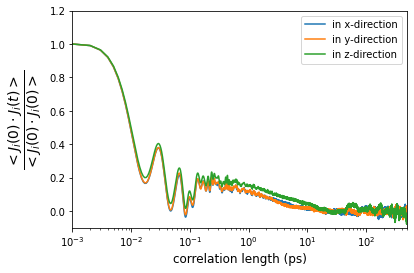

In [15]:
t = np.arange(0.001,len(acx)*.001+.001,0.001)

plt.plot(t,acx, label="in x-direction")
plt.plot(t,acy,label="in y-direction")
plt.plot(t,acz,label="in z-direction")
plt.xscale('log')
plt.ylim([-.1,1.2])
plt.xlim(0.001,500)
plt.legend()
plt.ylabel("$ \\frac{<J_i(0)\cdot J_i(t)>}{<J_i(0)\cdot J_i(0)>}$", fontsize =20)
plt.xlabel("correlation length (ps)", fontsize = 12)

We see that the $ A_{corr} = \frac{<J_i(0)\cdot J_i(t)>}{<J_i(0)\cdot J_i(0)>} $ has a lot of noise. According to numerous literature, this is due to computational error. Perhaps choosing a smaller timestep reduces this (unknown at the moment)? 
So we want to do a curve fit. 
Chen et al proposed a double exponential fit of the form:

$ A_{corr}(t) = \frac{Cor(t)}{Cor(0)} = A_1 e^{-t/\tau_1} + A_2 e^{-t/\tau_2} +Y_0 $

We can then use Scipy's optimize curve fit to find this function and solve for both $ \tau_1$, $\tau_2$, $A_1$, $A_2$, $Y_0$

Chen, J., Zhang, G., & Li, B. (2010). How to improve the accuracy of equilibrium molecular dynamics for computation of thermal conductivity?. Physics Letters A, 374(23), 2392-2396.


In [107]:
#Define function for fitting as Chen et al said: double exponential
def ACF_fit(x, A, B, C, n, m):
    return A*np.exp(-x/n)+B*np.exp(-x/m)+C

In [17]:
x = np.arange(0.001,len(acx)*.001+.001,0.001)
pars, cov = curve_fit(ACF_fit, x, acx)
print(pars)

C:\Users\Ern\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ern\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ern\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in add
  This is separate from the ipykernel package so we can avoid doing imports until


[ 1.08755952e+00  1.41178846e-01 -3.22215666e-04  8.94234868e-03
  4.22784998e+00]


We have obtained all 5 parameters. Our last to, labeled in our script as 'n' and 'm' are our two relaxation times for fast optical phonons and acoustic phonons, $\tau_1$ and $\tau_2$ respectively. 

Text(0.5, 0, 'correlation length (ps)')

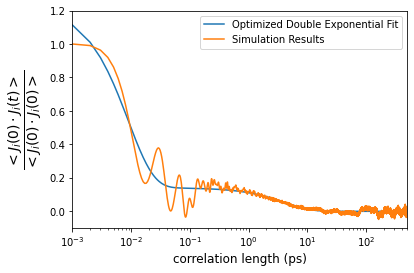

In [18]:
plt.plot(x,ACF_fit(x, pars[0],pars[1],pars[2],pars[3],pars[4]), label="Optimized Double Exponential Fit")
plt.plot(x,acx, label="Simulation Results")
plt.xscale('log')
plt.ylim([-.1,1.2])
plt.xlim(0.001,500)
plt.legend()
plt.ylabel("$ \\frac{<J_i(0)\cdot J_i(t)>}{<J_i(0)\cdot J_i(0)>}$", fontsize =20)
plt.xlabel("correlation length (ps)", fontsize = 12)

We can see that the double exponential fit is very close. To sum up Chen et al's work, the two exponential functions are because of the relaxation time due to fast (short wavelength) optical phonons and slow (long wavelength) phonons corresponding to $\tau_1$ and $\tau_2$ respectively. 

Now we will find the relative error fluctuation (description of the numerical error)

$F(t) = | \frac{\sigma(Cor(t))}{E(Cor(t))} | $

Where $\sigma$ is the standard deviation and $E$ is the mean
NOTE: standard deviation is the square of the variance

Note: The $t$ dependence is actually not from 0 to $t$ but from $t$ to $\delta t$

where $\delta t$ is some interval of time. Chen et all says choosing $\delta t$ affects the cuttoff time $\tau_c$. I have found the larger you choose the more smoothed out the $F(t)$ and $E$ graphs get. A good choice that shows the beginning of smooting is 8000 which corresponds to 8 ps and is not to computationally intensive

In [93]:
%%time

F = np.zeros(len(Jx))
cor = acx * Jx.var()
for j in range(500000):
    F[j] = np.absolute(np.sqrt(cor[j:j+8000].var())/np.mean(cor[j:j+8000]))

Wall time: 25.8 s


In [66]:
np.absolute(np.sqrt(cor[:100010].var())/np.mean(cor[:100010]))

5.558903741246144

No handles with labels found to put in legend.


Text(0.5, 0, 'correlation length (ps)')

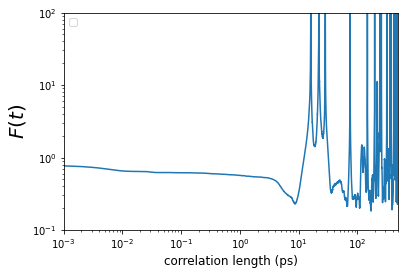

In [94]:
plt.plot(x[:500000],F[:500000])
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.1,100])
plt.xlim(0.001,500)
plt.legend()
plt.ylabel("$ F(t)$", fontsize =20)
plt.xlabel("correlation length (ps)", fontsize = 12)

In figure 1 of Chen et al, inside the $F(t)$ plots they also show plots of:
$E(Cor(t)/Cor(0))$ which is just $E(A_{corr}(t))$

Note: The $t$ dependence is actually not from 0 to $t$ but from $t$ to $\delta t$

we have chosen $\delta t$ to be 8000 steps or 8 ps as mentioned above

In [95]:
%%time
E = np.zeros(len(acx))
for j in range(500000):
    E[j] = np.mean(acx[j:j+8000])

Wall time: 5.88 s


No handles with labels found to put in legend.


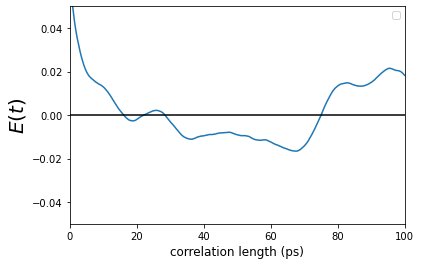

In [100]:
plt.plot(x[:500000],E[:500000])
#plt.xscale('log')
#plt.yscale('log')
plt.ylim([-0.05 ,0.05])
plt.xlim(0,100)
plt.legend()
plt.ylabel("$ E(t)$", fontsize =20)
plt.xlabel("correlation length (ps)", fontsize = 12)
plt.axhline(y=0, color='black')

We can see that the first peak in $F(T)$ and first zero in $E(T)$ correspond to each other at around 18 ps. 

We will call this $\tau_c = 18 ps$

---
Now we will begin integration process. We will use loop that does trapezoidal integration. First, we loop to calculate trapezoidal area for each individual point(bin). Then we sum according to correlation time length (sum trapezoids). The reason for implementing my own trapezoidal integration loop is because numpy's trapezoidal integration function must be implemented for every new correlation time length. This causes a huge slowdown. It is better to calculate the area for each individual dt integration and sum them up according to correlation time length

NOTE: We will just show it to 500 ps because Chen et al only has to this time.

In [35]:
%%time
kx = np.zeros(500000)
for j in range(1,500000):
    kx[j] = 0.001/2*(acx[j]+acx[j-1])
    

Wall time: 495 ms


In [36]:
%%time
kkx = np.zeros(500000)
for j in range(1,500000):
    kkx[j] = np.sum(kx[:j])

Wall time: 50.1 s


Now we will do it for the double exponential fit

In [21]:
%%time
acxf = ACF_fit(x[:500000], pars[0],pars[1],pars[2],pars[3],pars[4])
fitkx = np.zeros(500000)
for j in range(1,500000):
    fitkx[j] = 0.001/2*(acxf[j]+acxf[j-1])
    

Wall time: 526 ms


In [22]:
%%time
fitkkx = np.zeros(500000)
for j in range(1,500000):
    fitkkx[j] = np.sum(fitkx[:j])

Wall time: 51.4 s


To plot Thermal conductivity we note that our previous autocorrelation function was normalized by the variance. So we must multiply by the variance $\sigma$ of $J_x$. 

Second, we note that the units of $J_x$ coming out of lammps are specific (using metal units). 
The input file uses metal units and divides the total $J$ by the volume of the system in order to get units of $\frac{eV}{Å^{2} ps}$ which we must square for the correlation function:

$\frac{eV^2}{Å^{4} ps^2}$

BUt for the thermal conductivity integral we multiply by our time dt which is in $ps$ so that it cancels one of the $ps$ so we have: $\frac{eV^2}{Å^{4} ps}$

The LAMMPS page:
https://lammps.sandia.gov/doc/compute_heat_flux.html

Tells us to multiply by the volume over temperature such as:

$\frac{V}{k_b T^2}$ 

Multiplying the units of this with the above gives us:

$ \frac{Å^3}{\frac{eV}{K} K^2} \cdot \frac{eV^2}{Å^{4}ps}  = \frac{eV}{ps\cdot Å\cdot K}$

So then to get into SI units we must convert by the following:

$\frac{eV}{ps\cdot Å\cdot K}\cdot (1.6E-19 J/eV)/(1E-12 s/ps)/(1E-10 m/Å)$

We must remember, not only to multiply by the above conversion factors but also by the Volume in angstroms, divide by boltzman constant, and divide by the square of temperature in kelvin.


Text(0.5, 0, 'correlation length (ps)')

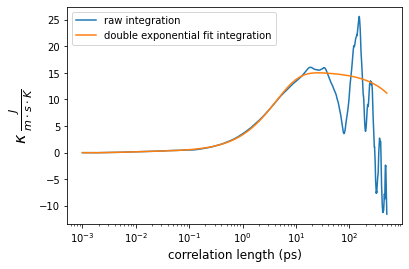

In [37]:
V = np.power(15.0*3.567,3)
T = 1000.0
kapx = kkx[:500000]*Jx.var()*V/np.power(T,2)*(1.6*np.power(10.0,-19))/(np.power(10.0,-12))/(np.power(10.0,-10))/(8.567*np.power(10.0,-5))
fitkapx = fitkkx[:500000]*Jx.var()*V/np.power(T,2)*(1.6*np.power(10.0,-19))/(np.power(10.0,-12))/(np.power(10.0,-10))/(8.567*np.power(10.0,-5))
plt.plot(x[:500000],kapx, label = "raw integration")
plt.plot(x[:500000],fitkapx, label="double exponential fit integration")
plt.xscale('log')
plt.legend()
plt.ylabel("$ \kappa \; \\frac{J}{m\cdot s \cdot K}$", fontsize =16)
plt.xlabel("correlation length (ps)", fontsize = 12)

We can calculate the max thermal conductivity from the double exponential fit

In [38]:
np.max(fitkapx)

15.014367362473864

To get graphs equivalent to many other works, we want to see it in linear axis:

Text(0.5, 0, 'correlation length (ps)')

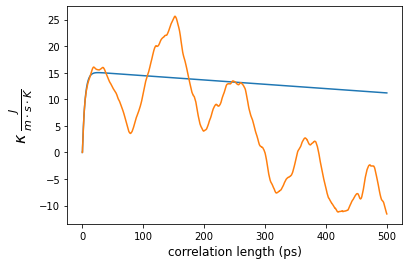

In [42]:
plt.plot(x[:500000],fitkapx[:500000], label="double exponential fit integration")
plt.plot(x[:500000],kapx[:500000], label = "raw integration")
plt.ylabel("$ \kappa \; \\frac{J}{m\cdot s \cdot K}$", fontsize =16)
plt.xlabel("correlation length (ps)", fontsize = 12)

---
Now we can do the formulaic calculation of the thermal conductivity given by equations (5) and (6) in Chen et al

From the above double exponential fit we found the following parameters:

$A_1 = 1.08755952$

$A_2 = 0.141178846$

$Y_0 = -0.000322215666$

$\tau_1 = 0.00894234868$

$\tau_2 = 4.22784998$

And we get from the Chen et al's equations:

(5) &emsp;  &emsp;     $\kappa_C(t) = \frac{Cor(0)}{3 k_B T^2 V} (A_1 \tau_1 + A_2 \tau_2)$

(6)  &emsp; &emsp;   $\kappa_F(t) = \frac{Cor(0)}{3 k_B T^2 V} (A_1 \tau_1 + A_2 \tau_2 + Y_0 \tau_c)$

The only thing we need to consider is the actual constants to be multiplied in front $\frac{Cor(0)}{3 K_B T^2 V}$so that they conform to our LAMMPS output units. So we will multiply with what we did in the previous Thermal Conductivity calculations


In [117]:
FrontConst = Jx.var()*V/np.power(T,2)*(1.6*np.power(10.0,-19))/(np.power(10.0,-12))/(np.power(10.0,-10))/(8.567*np.power(10.0,-5))

A1 = 1.08755952
A2 = 0.141178846
Y = -0.000322215666
tau1 = 0.00894234868
tau2 = 4.22784998
tauc = 18

kc = FrontConst*(A1*tau1+A2*tau2)
kf = FrontConst*(A1*tau1+A2*tau2+Y*tauc)

print('Thermal conductivity with out Yo = ',kc, 'W/m*s')
print('Thermal conductivity with     Yo = ',kf, 'W/m*s')


Thermal conductivity with out Yo =  15.28676236894355 W/m*s
Thermal conductivity with     Yo =  15.140603117355637 W/m*s


Notice that they are almost the same. In Chen et al, they claim the exponential $k_F$ gives closer results to experimental values and direct integration (which we did above). Our direct integration above shows almost exact values to those from the double exponential fit so it is not surprising. 